In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from IPython import display

import numpy as np
import pandas as pd

from numpy.linalg import norm, svd

import itertools
import pickle
import math
import re

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import logging

from util.word2vec_as_MF import Word2vecMF
from util.functions import *
from util.visualize import *

import time
dimension = 100
model =  Word2vecMF()


Please run:
  python setup.py build_ext --inplace


CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.53 µs
[0] [0.0]
([0.0], [0])


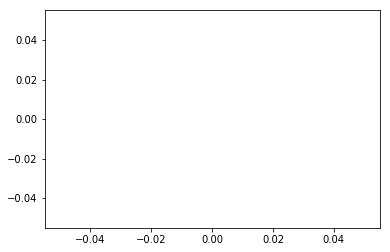

In [76]:

def analogy_score(from_folder, index, evalX):
    from_folder='enwik-200/'+from_folder
    
    
    C, W = model.load_CW(from_folder, index)
    normInv = np.array([1./n if n else 0. for n in np.linalg.norm(W, axis=0)])
    W = W*normInv

    predict = W.T[evalX[:,1]]-W.T[evalX[:,0]]+W.T[evalX[:,2]] # (:, dim)
    
    closest = np.argmax(-2*predict.dot(W), axis=1)
    
    #eturn predict, (predict == evalX[:,3]).mean(), predict.shape, evalX[:,3].shape
    return (closest == evalX[:,3]).mean()

def analogy_dict(from_folder=datapath,MAX_ITER=100, plot_corrs=False):
    count = 0;
    model =  Word2vecMF()
    model.vocab = model.load_vocab('enwik-200/'+from_folder+'/vocab.txt')[1]
    vocab = model.vocab
    X = []
    with open('benchmark/EN-GOOGLE.txt') as file:
        for line in file:
            tokens = line.split()
            if tokens[0] in vocab and tokens[1] in vocab and tokens[2] in vocab and tokens[3] in vocab:
                X.append([vocab[tokens[0]], vocab[tokens[1]], vocab[tokens[2]], vocab[tokens[3]]])
        X=np.array(X)
        
    filelist = glob.glob('enwik-200/'+from_folder+'/W*.npz')
    steps = sorted([int(file.split('/')[-1][1:-4]) for file in filelist])
    steps = [step for step in steps if step<MAX_ITER]
    
    analogy= [analogy_score(from_folder=datapath, index=step, evalX=X) for step in steps]
    print(steps, analogy)
    plt.plot(steps, analogy)
    
    return analogy, steps 
  
%time

label_list= {'PSiter_from9PPM_dim100_step1e-05_0.0': 'BFGD 1.0-8'}
for datapath in label_list.keys():
    print(analogy_dict(datapath, MAX_ITER=1))

enwik-200/BFGDiter_from9PPM_dim100_step5e-09_0.0/corrDict.pkl created.
CPU times: user 1min 55s, sys: 7.77 s, total: 2min 3s
Wall time: 1min 44s


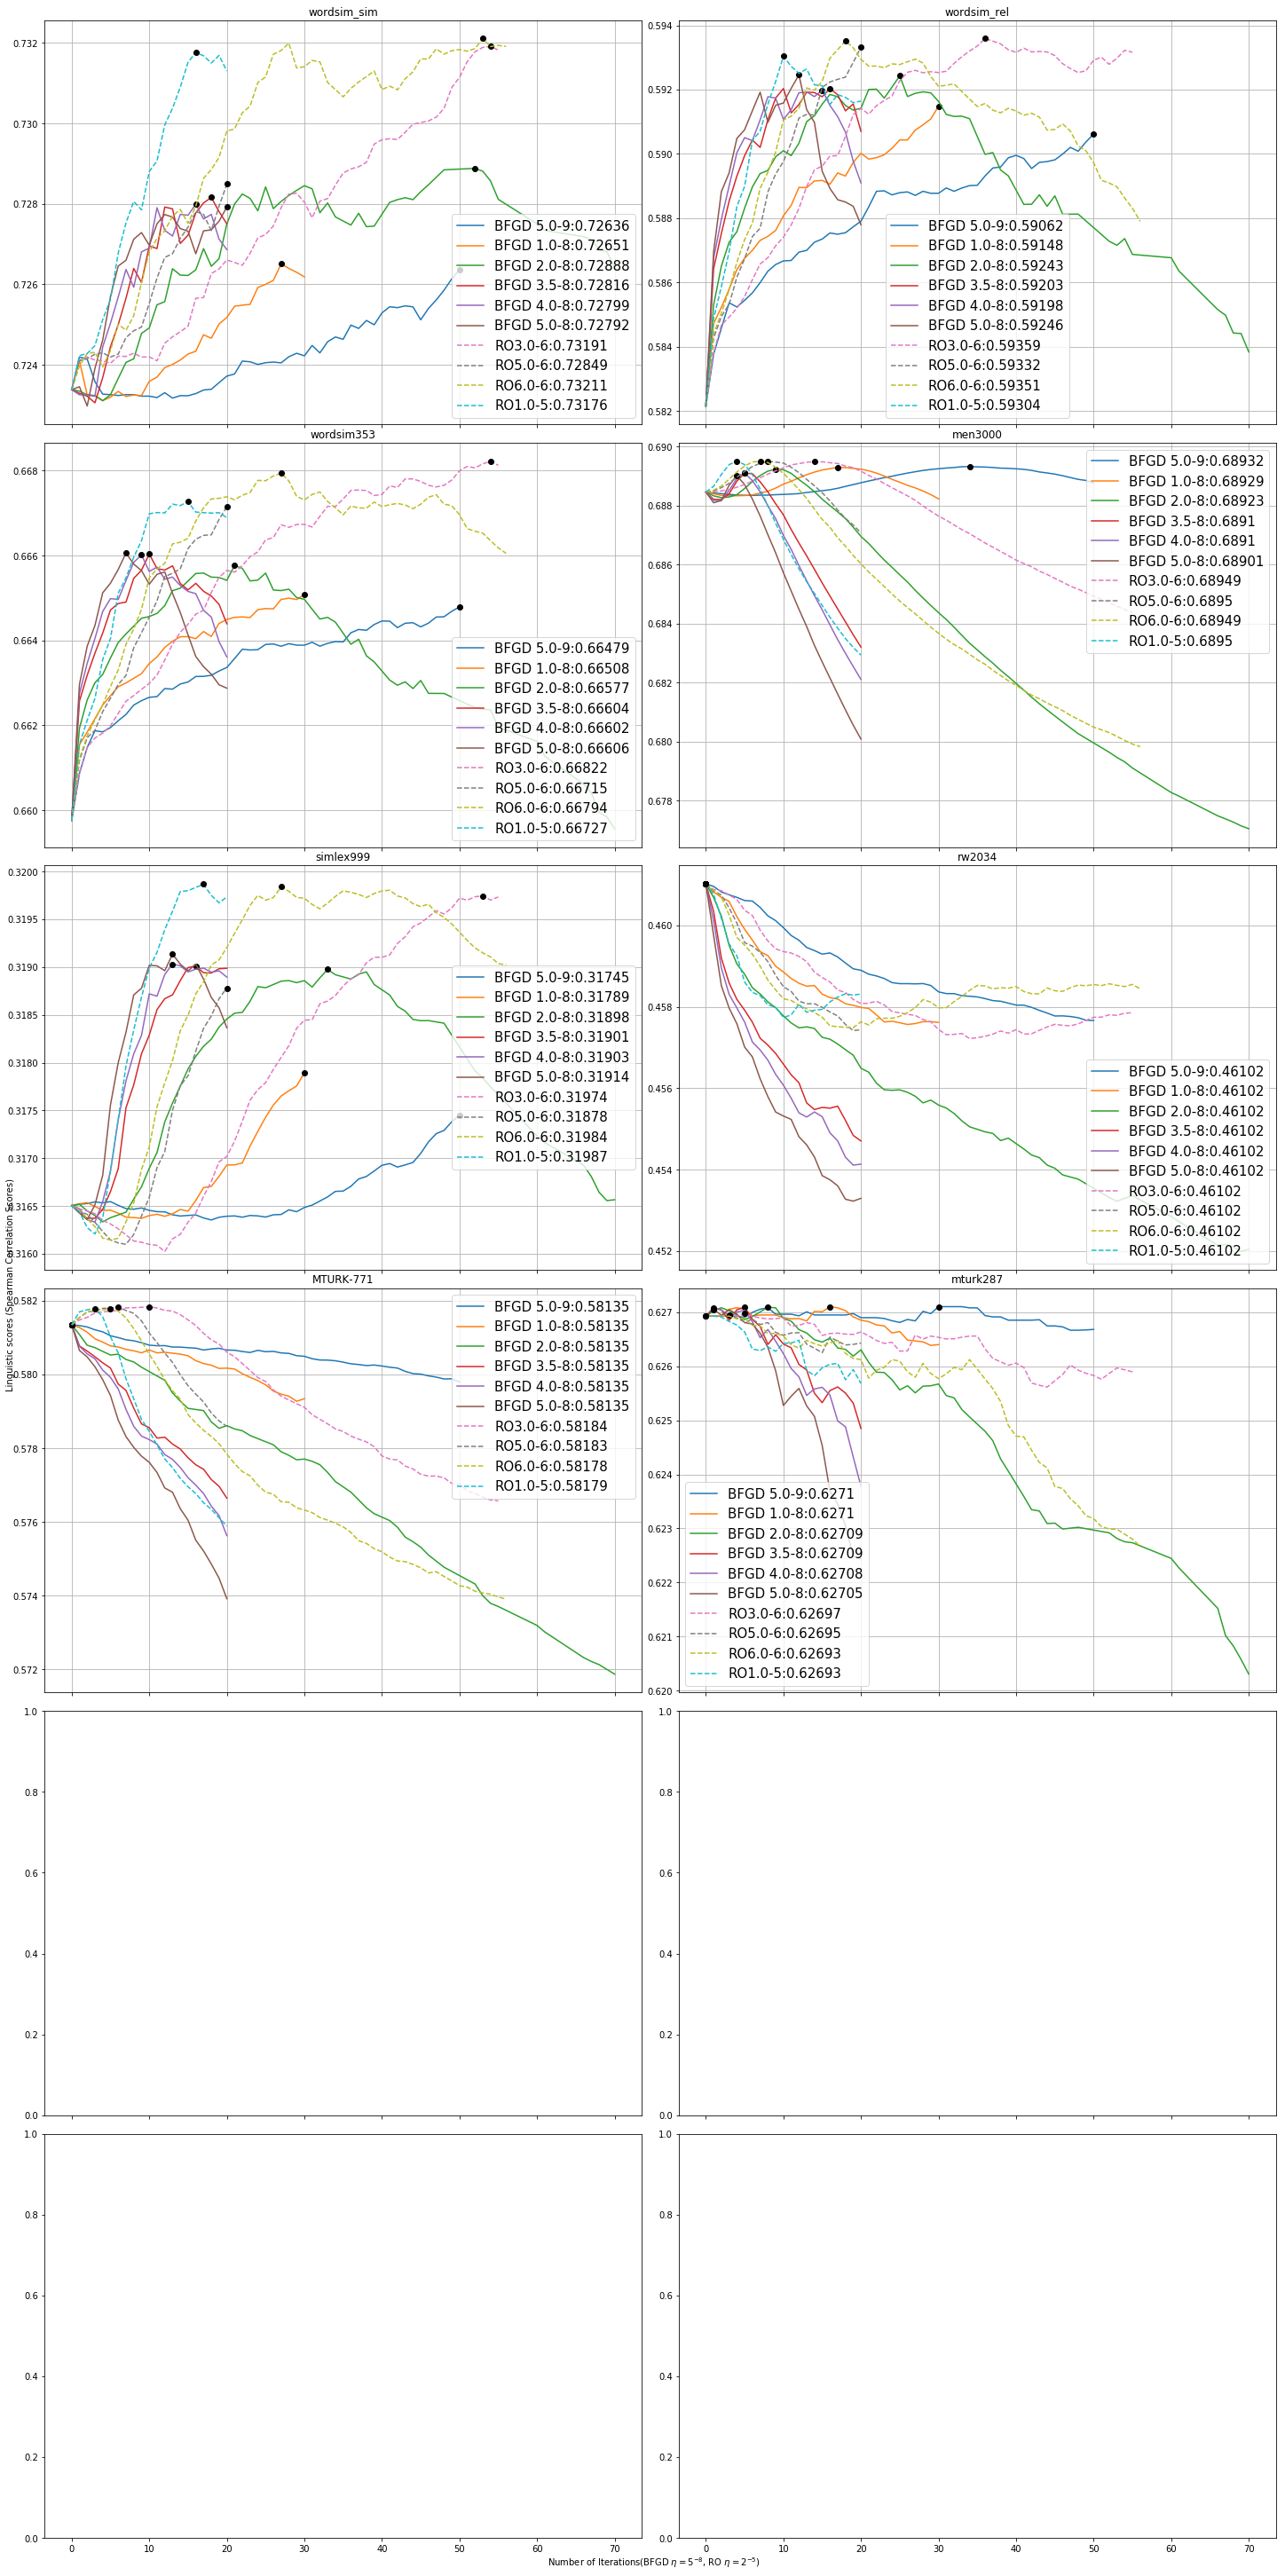

In [61]:
%%time
%matplotlib inline
#datapath='enwik-200/BFGDiter_fromenwik8_dense_dim100_step1e-07_0.0'
#datapath='enwik-200/PSiter_fromenwik8_dim100_step1e-05_0.0'
#datapath='enwik-200/PSiter_fromenwik8PMM_dim100_step1e-05_0.0'
#datapath='enwik-200/PSiter_from9X0_dim100_step5e-05_0.0'
#datapath='enwik-200/BFGDiter_from8PMM_dim100_step2.59178322952e-08_0.0'
#datapath='enwik-200/BFGDiter_from8X0_dim100_step2.59178322952e-08_0.0'
#datapath= 'enwik-200/PSiter_from9PPM_dim100_step1e-05_0.0'
#datapath= 'enwik-200/PS10iter_fromSVD_dim100_step5e-05_factors/'
#datapath='enwik-200/BFGDiter_from9X0_dim100_step2.441114203507839e-09_0.0'
#datapath='initializations/SPPMI5/'
#datapath='enwik-200/BFGDiter_from9PPM_dim100_step2e-05_0.0'
#datapath='enwik-200/biasedRevBFGDiter_from8SPPMI5_dim100_step1e-07_0.0'
#datapath='enwik-200/PSiter_from9PPM_dim100_step2e-05_0.0'

label_list={
    #'BFGDiter_from9PPM_dim100_step5.9e-08_0.0': 'BFGD 5.9-8',
    'BFGDiter_from9PPM_dim100_step5e-09_0.0': 'BFGD 5.0-9',
    'BFGDiter_from9PPM_dim100_step1e-08_0.0': 'BFGD 1.0-8',
    'BFGDiter_from9PPM_dim100_step2e-08_0.0': 'BFGD 2.0-8',
    'BFGDiter_from9PPM_dim100_step3.5e-08_0.0': 'BFGD 3.5-8',
    'BFGDiter_from9PPM_dim100_step4e-08_0.0': 'BFGD 4.0-8',
    'BFGDiter_from9PPM_dim100_step5e-08_0.0': 'BFGD 5.0-8',
   
    #####'PSiter_from9PPM_dim100_step2e-05_0.0': 'RO',
    
    #'PSiter_from9PPM_dim100_step3e-05_0.0' : 'RO3 bad',
    #'PSiter_from9PPM_dim100_step2e-05_0.0' : 'RO2 bad',    
    #'PSiter_from9PPM_dim100_step1.5e-05_0.0' : 'RO1.5',
    'PSiter_from9PPM_dim100_step3e-06_0.0' : 'RO3.0-6',
    'PSiter_from9PPM_dim100_step5e-06_0.0' : 'RO5.0-6',
    'PSiter_from9PPM_dim100_step6e-06_0.0' : 'RO6.0-6',
    'PSiter_from9PPM_dim100_step1e-05_0.0' : 'RO1.0-5'

    #'biasedRevBFGDiter_from9PPM_dim100_step5e-08_0.0': 'unbalanced SVD $C=U$, $W=SV$',
    #'revBFGDiter_from9PPM_dim100_step5e-08_0.0': 'balanced SVD $C=U\sqrt{S}$, $W=\sqrt{S}V$'
}
'''sorted_names = ['wordsim_sim', 'wordsim_rel', 'wordsim353','men3000','simlex999',
                'rw2034', 'MTURK-771', 'mturk287', 'verb143','rg65', 'mc30']'''
sorted_names = ['wordsim_sim', 'wordsim_rel', 'wordsim353','men3000','simlex999',
                'rw2034', 'MTURK-771', 'mturk287']
#sorted_names = ['wordsim_sim', 'wordsim_rel']
column = 2
row = 6
fig, axarr = plt.subplots(row, column, sharex=True, figsize=(20, 40))
fig.tight_layout()
for datapath in label_list.keys():
    datapath = 'enwik-200/'+datapath
    for idx, name in enumerate(sorted_names):
        i=idx//column
        j=idx%column
        axarr[i,j].set_title(name)   

        axarr[i,j].grid(True)
        ben_dict, steps =bench_dict(from_folder=datapath, 
              MAX_ITER=100,plot_corrs=False)
        max_dict= {benchmark: 
               (round(max(ben_dict[benchmark]),5), steps[np.argmax(ben_dict[benchmark])]) 
                                                                           for benchmark in ben_dict.keys()}
#print(corr_dict1)
#corr_dict=corr_dict1
        if -1==datapath.find('BFGD'):
            axarr[i,j].plot(steps, ben_dict[name], linestyle= '--', 
                            label=label_list[datapath.split('/')[1]]+':'+str(max_dict[name][0]))
        else:
            axarr[i,j].plot(steps, ben_dict[name], 
                            label=label_list[datapath.split('/')[1]]+':'+str(max_dict[name][0]))
        
        #print(max_dict[name])
        axarr[i,j].plot(max_dict[name][1], max_dict[name][0], 'ko')    
         

    #print(datapath.split('/'), max_dict)
    for idx, name in enumerate(sorted_names):
        i=idx//column
        j=idx%column
        axarr[i,j].legend(loc='best', fontsize=15)
fig.text(-0.003,0.5, "Linguistic scores (Spearman Correlation Scores)", ha="center", va="center",  rotation=90)
fig.text(0.5,0.0, "Number of Iterations(BFGD $\eta=5^{-8}$, RO $\eta=2^{-5}$)", ha="center", va="center")

In [ ]:
sentences=load(from_file='data/enwik8.txt')
skip = Word2Vec(sentences, size=dimension, min_count=5)

In [ ]:
Path = 'datasets/men3000.csv'
print(Path)

df = pd.read_csv(Path,header=None, delimiter=';');
'''score1, _, _, chosen_pairs = correlation(model = model, benchmark = df, 
                                            from_folder='enwik-200/AMiter_fromPMM_D2_dim20_step1e-05_0.006',
                                           index=934);
print(score1, len(chosen_pairs))

score2, _, _, chosen_pairs = correlation(model = model, benchmark = df,
                                            from_folder='enwik-200/PSiter_fromSVD_dim20_step5e-05_0.0',
                                           index=360000);
print(score2, len(chosen_pairs))'''

score3, _, _, chosen_pairs = corr_word2vec(skip ,df, model_vocab=model.vocab)
print(score3, len(chosen_pairs))

dictionary['Evaluation'].append(Path.split('/')[1].split('.')[0])
'''dictionary['BFGD'].append(score1)
dictionary['RO'].append(score2)'''
dictionary['word2vec'].append(score3)
dictionary['number of pairs'].append(len(chosen_pairs))

In [ ]:
Path = 'datasets/verb143.csv'
print(Path)

df = pd.read_csv(Path,header=None, delimiter=';');
score1, _, _, chosen_pairs = correlation(model = model, benchmark = df, 
                                            from_folder='enwik-200/AMiter_fromPMM_D2_dim20_step1e-05_0.006',
                                           index=190000);
print(score1, len(chosen_pairs))

score2, _, _, chosen_pairs = correlation(model = model, benchmark = df,
                                            from_folder='enwik-200/PSiter_fromSVD_dim20_step5e-05_0.0',
                                           index=360000);
print(score2, len(chosen_pairs))

score3, _, _, chosen_pairs = corr_word2vec(skip ,df, model_vocab=model.vocab)
print(score3, len(chosen_pairs))

dictionary['Evaluation'].append(Path.split('/')[1].split('.')[0])
dictionary['BFGD'].append(score1)
dictionary['RO'].append(score2)
dictionary['word2vec'].append(score3)
dictionary['number of pairs'].append(len(chosen_pairs))

In [ ]:
Path = 'datasets/wordsim353.csv'
print(Path)

df = pd.read_csv(Path,header=None, delimiter=';');
'''score1, _, _, chosen_pairs = correlation(model = model, benchmark = df, 
                                            from_folder='enwik-200/AMiter_fromPMM_D2_dim20_step1e-05_0.006',
                                           index=190000);
print(score1, len(chosen_pairs))

score2, _, _, chosen_pairs = correlation(model = model, benchmark = df,
                                            from_folder='enwik-200/PSiter_fromSVD_dim20_step5e-05_0.0',
                                           index=360000);
print(score2, len(chosen_pairs))'''

score3, _, _, chosen_pairs = corr_word2vec(skip ,df, model_vocab=model.vocab)
print(score3, len(chosen_pairs))

dictionary['Evaluation'].append(Path.split('/')[1].split('.')[0])
#dictionary['BFGD'].append(score1)
#dictionary['RO'].append(score2)
dictionary['word2vec'].append(score3)
dictionary['number of pairs'].append(len(chosen_pairs))

In [ ]:
Path = 'datasets/MTURK-771.csv'
print(Path)

df = pd.read_csv(Path,header=None, delimiter=',');
score1, _, _, chosen_pairs = correlation(model = model, benchmark = df, 
                                            from_folder='enwik-200/AMiter_fromPMM_D2_dim20_step1e-05_0.006',
                                           index=190000);
print(score1, len(chosen_pairs))

score2, _, _, chosen_pairs = correlation(model = model, benchmark = df,
                                            from_folder='enwik-200/PSiter_fromSVD_dim20_step5e-05_0.0',
                                           index=360000);
print(score2, len(chosen_pairs))

score3, _, _, chosen_pairs = corr_word2vec(skip ,df, model_vocab=model.vocab)
print(score3, len(chosen_pairs))

dictionary['Evaluation'].append(Path.split('/')[1].split('.')[0])
dictionary['BFGD'].append(score1)
dictionary['RO'].append(score2)
dictionary['word2vec'].append(score3)
dictionary['number of pairs'].append(len(chosen_pairs))

In [ ]:
Path = 'datasets/mturk287.csv'
print(Path)

df = pd.read_csv(Path,header=None, delimiter=';');
score1, _, _, chosen_pairs = correlation(model = model, benchmark = df, 
                                            from_folder='enwik-200/AMiter_fromPMM_D2_dim20_step1e-05_0.006',
                                           index=190000);
print(score1, len(chosen_pairs))

score2, _, _, chosen_pairs = correlation(model = model, benchmark = df,
                                            from_folder='enwik-200/PSiter_fromSVD_dim20_step5e-05_0.0',
                                           index=360000);
print(score2, len(chosen_pairs))

score3, _, _, chosen_pairs = corr_word2vec(skip ,df, model_vocab=model.vocab)
print(score3, len(chosen_pairs))

dictionary['Evaluation'].append(Path.split('/')[1].split('.')[0])
dictionary['BFGD'].append(score1)
dictionary['RO'].append(score2)
dictionary['word2vec'].append(score3)
dictionary['number of pairs'].append(len(chosen_pairs))

In [ ]:
Path = 'datasets/rw2034.csv'
print(Path)

df = pd.read_csv(Path,header=None, delimiter=';');
'''score1, _, _, chosen_pairs = correlation(model = model, benchmark = df, 
                                            from_folder='enwik-200/AMiter_fromPMM_D2_dim20_step1e-05_0.006',
                                           index=190000);
print(score1, len(chosen_pairs))

score2, _, _, chosen_pairs = correlation(model = model, benchmark = df,
                                            from_folder='enwik-200/PSiter_fromSVD_dim20_step5e-05_0.0',
                                           index=360000);
print(score2, len(chosen_pairs))'''

score3, _, _, chosen_pairs = corr_word2vec(skip ,df, model_vocab=model.vocab)
print(score3, len(chosen_pairs))

dictionary['Evaluation'].append(Path.split('/')[1].split('.')[0])
'''dictionary['BFGD'].append(score1)
dictionary['RO'].append(score2)'''
dictionary['word2vec'].append(score3)
dictionary['number of pairs'].append(len(chosen_pairs))

In [ ]:
Path = 'datasets/simlex999.csv'
print(Path)

df = pd.read_csv(Path,header=None, delimiter=';');
score1, _, _, chosen_pairs = correlation(model = model, benchmark = df, 
                                            from_folder='enwik-200/AMiter_fromPMM_D2_dim20_step1e-05_0.006',
                                           index=190000);
print(score1, len(chosen_pairs))

score2, _, _, chosen_pairs = correlation(model = model, benchmark = df,
                                            from_folder='enwik-200/PSiter_fromSVD_dim20_step5e-05_0.0',
                                           index=360000);
print(score2, len(chosen_pairs))

score3, _, _, chosen_pairs = corr_word2vec(skip ,df, model_vocab=model.vocab)
print(score3, len(chosen_pairs))

dictionary['Evaluation'].append(Path.split('/')[1].split('.')[0])
dictionary['BFGD'].append(score1)
dictionary['RO'].append(score2)
dictionary['word2vec'].append(score3)
dictionary['number of pairs'].append(len(chosen_pairs))

In [ ]:
df = pd.DataFrame(dictionary)
cols = df.columns.tolist()
j = cols.index('Evaluation')
cols[0],cols[j]=cols[j], cols[0]
j = cols.index('number of pairs')
cols[-1],cols[j]=cols[j], cols[-1]
df=df[cols]
df.style

enwik8

In [ ]:
Path = 'datasets/verb143.csv'
print(Path)

df = pd.read_csv(Path,header=None, delimiter=';');
score1, _, _, chosen_pairs = correlation(model = model, benchmark = df, 
                                            from_folder='enwik-200/AMiter_fromPMM_D2_dim20_step1e-05_0.006',
                                           index=190000);
print(score1, len(chosen_pairs))

score2, _, _, chosen_pairs = correlation(model = model, benchmark = df,
                                            from_folder='enwik-200/PSiter_fromSVD_dim20_step5e-05_0.0',
                                           index=360000);
print(score2, len(chosen_pairs))

In [ ]:
from util.visualize import *

#Path = 'benchmark/simlex999.csv'
Path = 'benchmark/men3000.csv'
#Path = 'datasets/rw2034.csv'
#Path = 'benchmark/wordsim353.csv'
Path = 'benchmark/wordsim_sim.csv'
#Path = 'datasets/MTURK-771.csv'

#datapath='enwik-200/BFGDiter_fromenwik8_dim100_step1e-07_0.0'
#datapath='enwik-200/BFGDiter_fromenwik8_dim100_step1.49198074496e-08_0.0'
#datapath='enwik-200/BFGDiter_fromenwik8_dense_dim100_step1e-07_0.0'
#datapath='enwik-200/PSiter_fromenwik8_dim100_step1e-05_0.0'
#datapath='enwik-200/PSiter_from9PMM_dim100_step5e-05_0.0'
#datapath='enwik-200/BFGDiter_from8PMM_dim100_step2.59178322952e-08_0.0'
#datapath='enwik-200/BFGDiter_from9PMM_dim100_step2.441114203507839e-09_0.0'
#datapath='enwik-200/BFGDiter_from9X0_dim100_step2.441114203507839e-09_0.0'
#datapath='initializations/8SPPMI5/'
datapath='enwik-200/biasedRevBFGDiter_from8SPPMI5_dim100_step1e-07_0.0'

print(Path)

model.vocab=model.load_vocab(datapath+'/vocab.txt')[1]

score1, _, _, chosen_pairs = correlation(model=model, 
                                         benchmark = Path, 
                                         from_folder=datapath,
                                         index=0)
print(score1, len(chosen_pairs))

In [ ]:
%%time
%matplotlib inline
#datapath='enwik-200/BFGDiter_fromenwik8_dense_dim100_step1e-07_0.0'
#datapath='enwik-200/PSiter_fromenwik8_dim100_step1e-05_0.0'
#datapath='enwik-200/PSiter_fromenwik8PMM_dim100_step1e-05_0.0'
#datapath='enwik-200/PSiter_from9X0_dim100_step5e-05_0.0'
#datapath='enwik-200/BFGDiter_from8PMM_dim100_step2.59178322952e-08_0.0'
#datapath='enwik-200/BFGDiter_from8X0_dim100_step2.59178322952e-08_0.0'
#datapath= 'enwik-200/PSiter_from9PPM_dim100_step1e-05_0.0'
#datapath= 'enwik-200/PS10iter_fromSVD_dim100_step5e-05_factors/'
#datapath='enwik-200/BFGDiter_from9X0_dim100_step2.441114203507839e-09_0.0'
#datapath='initializations/SPPMI5/'
#datapath='enwik-200/PSiter_from9PMM_dim100_step5e-05_0.0'
datapath='enwik-200/PSiter_from8SPPMI5_dim100_step5e-05_0.0'
corr_dict=datasets_corr(from_folder=datapath, 
              MAX_ITER=500,plot_corrs=True)
max_dict= {benchmark: 
           (round(max(corr_dict[benchmark][1]),5), corr_dict[benchmark][0][np.argmax(corr_dict[benchmark][1])]) 
                                                                           for benchmark in corr_dict}
print(max_dict)

In [ ]:
%%time
%matplotlib inline
#datapath='enwik-200/BFGDiter_fromenwik8_dense_dim100_step1e-07_0.0'
#datapath='enwik-200/PSiter_fromenwik8_dim100_step1e-05_0.0'
#datapath='enwik-200/PSiter_fromenwik8PMM_dim100_step1e-05_0.0'
#datapath='enwik-200/PSiter_from9X0_dim100_step5e-05_0.0'
#datapath='enwik-200/BFGDiter_from8PMM_dim100_step2.59178322952e-08_0.0'
#datapath='enwik-200/BFGDiter_from8X0_dim100_step2.59178322952e-08_0.0'
#datapath= 'enwik-200/PSiter_from9PPM_dim100_step1e-05_0.0'
#datapath= 'enwik-200/PS10iter_fromSVD_dim100_step5e-05_factors/'
#datapath='enwik-200/BFGDiter_from9X0_dim100_step2.441114203507839e-09_0.0'
#datapath='initializations/SPPMI5/'
#datapath='enwik-200/PSiter_from9PMM_dim100_step5e-05_0.0'
datapath='enwik-200/biasedRevBFGDiter_from8SPPMI5_dim100_step1e-07_0.0'
#datapath='enwik-200/PSiter_from8SPPMI5_dim100_step5e-05_0.0'
corr_dict=datasets_corr(from_folder=datapath, 
              MAX_ITER=500,plot_corrs=True)
max_dict= {benchmark: 
           (round(max(corr_dict[benchmark][1]),5), corr_dict[benchmark][0][np.argmax(corr_dict[benchmark][1])]) 
                                                                           for benchmark in corr_dict}
print(max_dict)

In [ ]:
back={'wordsim_sim': 0.5083153291574576, 'wordsim_rel': 0.23051270181633066, 'wordsim353': 0.38721725196622725, 'men3000': 0.317088733602483, 'simlex999': 0.12770957277481088, 'rw2034': 0.3061656575652792, 'MTURK-771': 0.16602987279673054, 'rg65': 0.3058823529411765, 'verb143': 0.2739890953353197, 'mturk287': 0.351643421163816, 'mc30': 0.5}


In [ ]:
print({b: round(back[b],5)for b in back})